In [89]:
import cv2
import os, glob
from matplotlib import pyplot as plt
import numpy as np
from knn import knnDriver
from basicColoringAgent import getAll3x3,heapSort,setAll6, isMajority, getAvgValueLeft
def plot(img, title = 'Plot', scale=1):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4*scale,6*scale))
    plt.title(title)
    plt.imshow(img)

image = glob.glob('test2.jpg')
image = image[0]

In [90]:

print('Found: ' + image)

imData = cv2.imread(image)
scale = 100
height = int((imData.shape[0]) * scale/100)
width = int((imData.shape[1]) * scale/100)
dim = (width, height)
imData = cv2.resize(imData,dim,interpolation = cv2.INTER_AREA )


Found: test2.jpg


In [91]:
resX = imData.shape[1]
resY = imData.shape[0]
print(imData.shape)

halfPoint = int(resX/2)
trainImage = imData[:,:halfPoint,:]
testImage = imData[:,halfPoint:,:]


(100, 100, 3)


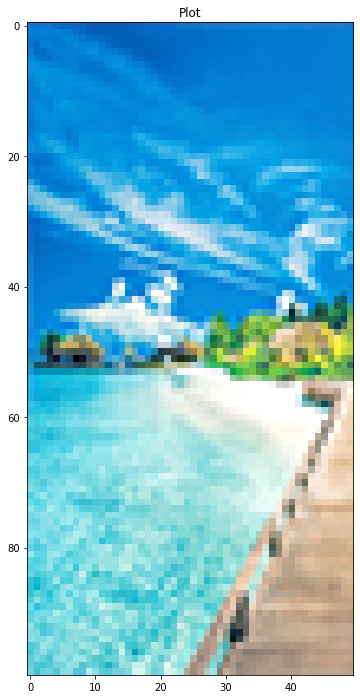

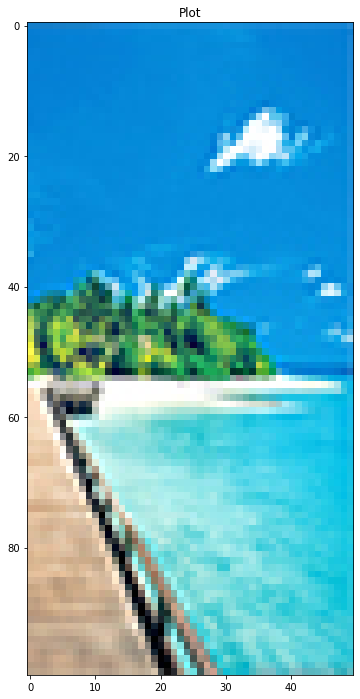

In [92]:
plot(trainImage,scale=2)
plot(testImage,scale=2)

In [93]:
def blueChannel(imData):
    resRow = imData.shape[0]
    resCol = imData.shape[1]
    row, col = resRow, resCol
    layerB = [[0 for x in range(row)] for y in range(col)] 
    counter = 0
    for i in imData:
        for j in i:
            rowB = int(counter / row)
            colB = int (counter % row)
            layerB[rowB][colB]=j[0]/255
            counter+=1
    return layerB


In [94]:
def greenChannel(imData):
    resRow = imData.shape[0]
    resCol = imData.shape[1]
    row, col = resRow, resCol
    layerG = [[0 for x in range(row)] for y in range(col)] 
    counter = 0
    for i in imData:
        for j in i:
            rowB = int(counter / row)
            colB = int (counter % row)
            layerG[rowB][colB]=j[1]/255
            counter+=1
    return layerG


In [95]:
def redChannel(imData):
    resRow = imData.shape[0]
    resCol = imData.shape[1]
    row, col = resRow, resCol
    layerR = [[0 for x in range(row)] for y in range(col)] 
    counter = 0
    for i in imData:
        for j in i:
            rowB = int(counter / row)
            colB = int (counter % row)
            layerR[rowB][colB]=j[2]/255
            counter+=1
    return layerR

In [96]:
def greyScale(imData):
    greyData = cv2.cvtColor(imData, cv2.COLOR_BGR2GRAY)
    resRow = imData.shape[0]
    resCol = imData.shape[1]
    row, col = resRow, resCol
    counter = 0
    layerR = [[0.0 for x in range(row)] for y in range(col)] 
    for i in greyData:
        for j in i:
            #print(j)
            #print(j/255)
            rowG = int(counter / row)
            colG = int (counter % row)
            layerR[rowG][colG]=j/255
            counter+=1
    return layerR
#print(greyScale(imData)[4])

In [97]:
import numpy as np
def padding(layerC, dimF): # padding each color layer
    col = len(layerC)
    row = len(layerC[0])
    arr = np.array(layerC)
    padRow = (row - (row - dimF + 1))//2
    padCol = (col - (col - dimF + 1))//2
    # print(padRow, padCol)
    arr = np.pad(arr,((padRow,padRow), (padCol,padCol)),'constant',constant_values = (0))
    # print(arr)
    # print(arr[5][5])
    return arr 


In [98]:
import random
def initWeights(row,col): # of connections between layers, para = # node in pre layer * # node in post layer
    #initialize filter with random values between 0 to 1
    matrix =[[0.0 for x in range(col)] for y in range(row)] 
    for i in range(row):
        for j in range(col):
            matrix[i][j]=random.uniform(-1,1)
    return matrix

In [99]:
import numpy as np
#test = padding(redChannel(imData),7)
def inputRecord(paddedLayerC, dimF, oriRow, oriCol): # to be used in main
    col = len(paddedLayerC)
    row = len(paddedLayerC[0])
    #making a 2D array of size row x col, with each element of 1D array of size dimF x dimF 
    #filteredLayer = [[0 for x in range(col * row)] for y in range(dimF * dimF)]
    #Filter arrays, need to use a for loop or something 
    records = []
    for i in range(int(dimF/2), oriRow - int(dimF/2)):
        for j in range(int(dimF/2), oriCol-int(dimF/2)):
            temp = list(paddedLayerC[(i-int(dimF/2)):(i+int(dimF/2)+1),(j-int(dimF/2)):j+int(dimF/2)+1].flatten())
            #print(len(temp))
            records.append(temp)
            
    return records 
#records = prepareLayerFilter(test,7,(imData.shape[0]),(imData.shape[1]))
#print(records)

In [100]:
# is this function still used or is it already been implmented in the feedforward fucntion?
def calculateFilter(records, preNode,postNode):#the col = #nodes need to be customized 
    #making a 2D array of size
    final = []
    #print(len(records))
    #print(len(records[0]))
    for i in range(len(records)):
        record = np.array(records[i])
        #print(len(record))
        filter = np.array(initFilterWeights(preNode,len(records[0]),postNode))
        res = np.dot(record,filter) # of nodes say 10
        final.append(res)
    return final # final col*row records of hidden nodes of #customized number

#tempRes = calculateFilter(records,7,10)

In [101]:
def relu(filRecords):
    #reluResult = np.empty_like(filRecords)
    for i in filRecords:
        if(i<0):
            i=0.0
    return filRecords
#print(relu(tempRes))

In [102]:
def nodeValues(preweight, postweight):#node values in a layer
    
    pre = np.array(preweight)
    post = np.array(postweight)
    res = np.dot(pre,post) # of nodes say 30
    return res # final node values for a single hidden layer

In [103]:
class HiddenLayer():
    def __init__(self, numNode):
        self.numNode = numNode
        self.nodeArr  = [0.0] * numNode
        self.weight = None
        self.error = None
        self.derError = None
        self.learningrate = 0.01
        self.updatedWeight = None

def initFeedForward(matrixOfLayers): #e.g. 49, 30, 25, 15, 5, 1
    #input record is a single 1x49 array of input
    #matrixOfLayers excluding input layer
    #Initialize weight matrix-----
    for i in range(len(matrixOfLayers)-1):
        matrixOfLayers[i].weight = initWeights(matrixOfLayers[i].numNode, matrixOfLayers[i+1].numNode)
    i = 0
    while i < len(matrixOfLayers)-1:
        i+=1
        # print("this is layer:"+str(i-1))
        # print( matrixOfLayers[i-1].nodeArr)
        # print( matrixOfLayers[i-1].weight)
        matrixOfLayers[i].nodeArr = nodeValues(matrixOfLayers[i-1].nodeArr, matrixOfLayers[i-1].weight)
        
        # float and nonetype
        matrixOfLayers[i].nodeArr = relu(matrixOfLayers[i].nodeArr)
    #return matrixOfLayers[len(matrixOfLayers)-1].nodeValues
    return matrixOfLayers


In [104]:
def error(expectedVal, actualVal):
    res = (expectedVal-actualVal)**2
    return res

In [105]:
def derError(expectedVal, actualVal):
    res = -2*(actualVal-expectedVal)
    return res

In [106]:
def helperDerError(arr, derError):
    for i in arr:
        # print("helper---")
        # print(i)
        # print(derError)
        i = i * derError[0]
    return arr

In [107]:
def backprobagation(initDerError, initError, matrixOfLayers):
    i = len(matrixOfLayers)-2 # start from second to last layer
    # output to last hidden layer
    #----------this is the derError matrix for each weight connection
    res = [initDerError]
    pre = np.array([res]) #1x1 # for matrix multiplication, have to do put a [] around it
    post = (np.array([matrixOfLayers[i].nodeArr])) #1x5
    # print("this is layer: " + str(i))
    # print(pre)
    # print(post)
    matrixOfLayers[i].derError = (np.dot(pre,post)).transpose() # 1x5 -> 5x1
    #print(matrixOfLayers[i].derError)
    print("derError Dim")
    print(len(matrixOfLayers[i].derError))
    print(len(matrixOfLayers[i].derError[0]))
    i-=1
    while i>=0: # check if i>=0
        pre = (np.array(matrixOfLayers[i+1].derError)) #5x1
        post = np.array([matrixOfLayers[i].nodeArr])#1x15
        print("olaolaolaoaa: " + str(i))
        
        print("preDim:"+str(len(pre))+" "+str(len(pre[0])))
        print("postDim:"+str(len(post))+" "+str(len(post[0])))
        matrixOfLayers[i].derError = np.array([helperDerError(np.dot(pre,post),res)]).transpose()# 5 x 15 -> 15 x 5 
        print("derError Dim")
        print(len(matrixOfLayers[i].derError))
        print(len(matrixOfLayers[i].derError[0]))
        i-=1
    #-----------Caclulate the error for each weight
    i = len(matrixOfLayers)-2
    pre = np.array(initError)
    post = np.array(matrixOfLayers[i].weight)
    matrixOfLayers[i].error = (np.dot(post,pre)).transpose()
    i-=1
    while i>=0:
        pre = np.array(matrixOfLayers[i+1].error)
        post = (np.array(matrixOfLayers[i].weight)).transpose()
        # print("this is layer: " + str(i))
        # print(pre)
        # print(post)
        matrixOfLayers[i].error = np.dot(pre,post)
        i-=1
    return matrixOfLayers


In [108]:
def matrixMul(matrix1,matrix2,alpha):
    # print("matrix size ----")
    # print(len(matrix1))
    # print(len(matrix1[0]))
    # print(len(matrix2))
    # print(len(matrix2[0]))
    res = [[0.0 for x in range(len(matrix1[0]))] for y in range(len(matrix1))] 
    for i in range(len(matrix1)):
        for j in range(len(matrix1[i])):
            res[i][j] = matrix1[i][j] * matrix2[i][j] * alpha
    return res

In [109]:
def feedForward(matrixOfLayer, alpha):
    # --- Updating all weight connections 
    for i in range(len(matrixOfLayer)-1):
        i+=1
        pre = np.array([matrixOfLayer[i-1].nodeArr]).transpose() # e.g. 1x49 -> 49 x1 (value of each node from pre layer)
        post = np.array(matrixOfLayer[i].error) # e.g. 1x30 (error of each node for current layer)
        # print("pre: "+str(i-1)+"post: "+str(i))
        # print( pre )
        # print( post )
        dot = np.dot(pre, post) # 49x30 (value*error for each weight)
        prod = matrixMul(dot, matrixOfLayer[i-1].derError, alpha) # alpha * error * derError * preNodeValue
        updatedWeight = np.add(np.array(matrixOfLayer[i-1].weight), prod)
    # --- feedforward weight to the network
    for i in range(len(matrixOfLayer)):
        i+=1
        matrixOfLayer[i].nodeArr = nodeValues(matrixOfLayer[i-1].nodeArr,matrixOfLayer[i-1].weight)
        matrixOfLayer[i].nodeArr = relu(matrixOfLayer[i].nodeArr)
    #return matrixOfLayers[len(matrixOfLayers)-1].nodeValues
    return matrixOfLayer



In [110]:
# main
# get image, then using 4 hidden layers 
dimF = 7 #dimension of filter
oriImgDim = imData.shape[0]
# get all three channel:
gray = greyScale(imData)
blue = blueChannel(imData)
green = greenChannel(imData)
red = redChannel(imData)
# padding channels 
padBlue = padding(blue,dimF)
padGreen = padding(green,dimF)
padRed = padding(red,dimF)
padGray = padding(gray,dimF)
# Making input records 
inputBlue = inputRecord(padBlue,dimF,oriImgDim,oriImgDim)
inputGreen = inputRecord(padGreen,dimF,oriImgDim,oriImgDim)
inputRed = inputRecord(padRed,dimF,oriImgDim,oriImgDim)
inputGray = inputRecord(padGray,dimF,oriImgDim,oriImgDim)

# Blue Channel:
# 1. Creating  hidden layers for blue channel 
bInput = HiddenLayer(49) #
bH1 = HiddenLayer(30)
bH2 = HiddenLayer(25)
bH3 = HiddenLayer(15)
bH4 = HiddenLayer(5)
bOutput = HiddenLayer(1)
# ---- Initialize network ----- 
nn = []
nn.append(bInput)
nn.append(bH1)
nn.append(bH2)
nn.append(bH3)
nn.append(bH4)
nn.append(bOutput)

#Initialize weights (random values) and nodeArr(which is all 0 as for now)
nn = initFeedForward(nn) # initialize weight and node Arr
expectedVal = blue[0][0] # expected blue value
actualVal = nn[len(nn)-1].nodeArr[0] 
derErrorx = derError(expectedVal,actualVal)
errorx = error(expectedVal,actualVal)
nn = backprobagation(derErrorx, errorx, nn)
# holding total error of the network
totalError = 0
counter = 0
# first epoch
for i in inputGray: 
    row = int(counter / oriImgDim)
    col = int(counter % oriImgDim)
    nn[0].nodeArr = i  # put input record to the nn input 
    nn = feedForward(nn, 0.01) # feed input forward into the network
    expectedVal = blue[row][col] # expected blue value
    actualVal = nn[len(nn)-1].nodeArr[0] # actual "guessed" value from input grayscale
    derErrorx = derError(expectedVal,actualVal)
    errorx = error(expectedVal,actualVal)
    totalError += error
    nn = backprobagation(derErrorx,errorx,nn)
    counter+=1


print(totalError)



derError Dim
5
1
olaolaolaoaa: 3
preDim:5 1
postDim:1 15
derError Dim
15
5
olaolaolaoaa: 2
preDim:15 5
postDim:1 25
derError Dim
25
5
olaolaolaoaa: 1
preDim:25 5
postDim:1 30
derError Dim
30
15
olaolaolaoaa: 0
preDim:30 15
postDim:1 49
derError Dim
49
25


IndexError: index 25 is out of bounds for axis 0 with size 25